Fresh Graduate Academy Digital Talent Scholarship Alur Belajar Machine Learning Developer
*   Nama : Abdurrahman Aziz 
*   Noreg : 1494037162101-1811

Pada proyek belajar machine learning ini menggunakan Ethereum historical dataset dari kaggle. Untuk mendownload dataset tersebut dapat menggunakan kaggle API. Dataset yang digunakan ETH_day.csv . Preprocessing pada data menggunakan minmax scaler. Model yang digunakan menggunakan LSTM yang menghasilkan MAE dibawah 10% threshold.


# Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import tensorflow as tf
import math
from scipy import stats
from google.colab import files

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams['figure.figsize']=(15,5)
plt.style.use('fivethirtyeight')

# Load Dataset

In [ ]:
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prasoonkottarathil/ethereum-historical-dataset

 23% 5.00M/21.4M [00:00<00:00, 50.8MB/s]
100% 21.4M/21.4M [00:00<00:00, 133MB/s] 


In [ ]:
!unzip '/content/ethereum-historical-dataset.zip'

Archive:  /content/ethereum-historical-dataset.zip
  inflating: ETH_1H.csv              
  inflating: ETH_1min.csv            
  inflating: ETH_day.csv             


In [ ]:
df = pd.read_csv('/content/ETH_day.csv')
df

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
1,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2,2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
3,2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
4,2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57
...,...,...,...,...,...,...,...,...
1433,2016-05-13,ETHUSD,10.20,11.59,10.20,10.69,1769.71,18923.55
1434,2016-05-12,ETHUSD,10.43,12.00,9.92,10.20,2072.56,22183.39
1435,2016-05-11,ETHUSD,9.68,10.47,9.68,10.43,3052.51,30978.11
1436,2016-05-10,ETHUSD,9.98,9.98,9.36,9.68,672.06,6578.20


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1438 non-null   object 
 1   Symbol      1438 non-null   object 
 2   Open        1438 non-null   float64
 3   High        1438 non-null   float64
 4   Low         1438 non-null   float64
 5   Close       1438 non-null   float64
 6   Volume ETH  1438 non-null   float64
 7   Volume USD  1438 non-null   float64
dtypes: float64(6), object(2)
memory usage: 90.0+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume ETH,Volume USD
count,1438.000000,1438.000000,1438.000000,1438.000000,1.438000e+03,1.438000e+03
mean,239.397149,248.919200,227.681446,239.468011,3.720638e+04,1.139557e+07
std,237.662224,248.677428,222.794938,237.606382,6.908336e+04,2.143780e+07
min,6.770000,7.290000,5.990000,6.770000,0.000000e+00,0.000000e+00
25%,79.782500,84.875000,74.677500,80.732500,7.020215e+03,7.541171e+05
50%,181.430000,187.020000,175.850000,181.430000,1.780439e+04,3.221372e+06
75%,297.735000,306.015000,287.427500,297.502500,4.204451e+04,1.204918e+07
max,1381.850000,1420.010000,1270.000000,1381.850000,1.827755e+06,2.221193e+08


In [ ]:
df.drop(df.columns[[1, 2, 3, 4, 6, 7]], axis=1, inplace=True)
df = df.sort_values(by='Date')
df

,Date,Close
1437,2016-05-09,9.98
1436,2016-05-10,9.68
1435,2016-05-11,10.43
1434,2016-05-12,10.20
1433,2016-05-13,10.69
...,...,...
4,2020-04-11,158.66
3,2020-04-12,158.56
2,2020-04-13,156.97
1,2020-04-14,158.61


In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df = df.set_index('Date')
df.head()

,Close
Date,
2016-05-09,9.98
2016-05-10,9.68
2016-05-11,10.43
2016-05-12,10.20
2016-05-13,10.69


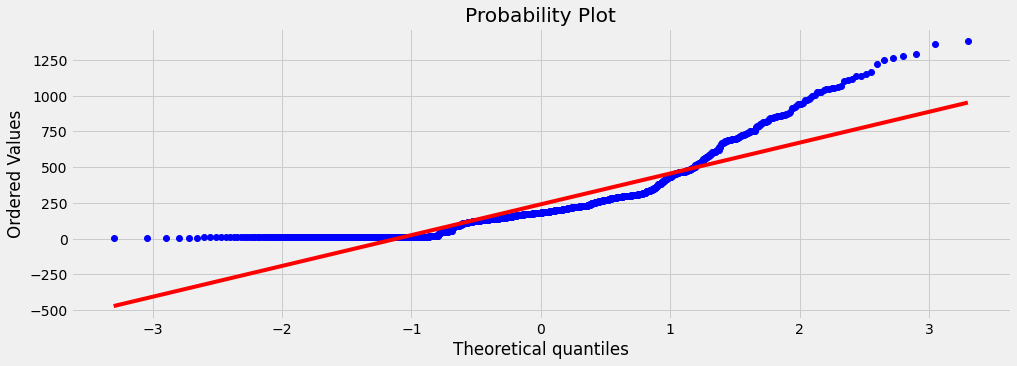

In [ ]:
stats.probplot(df['Close'], plot=pylab)
pylab.show()

In [ ]:
def ADF(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[2]}')
    print(f'p-value: {result[1]:.20f}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
                        
def ACF_and_PACF(data):
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=30, ax=ax1) 
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=30, ax=ax2)

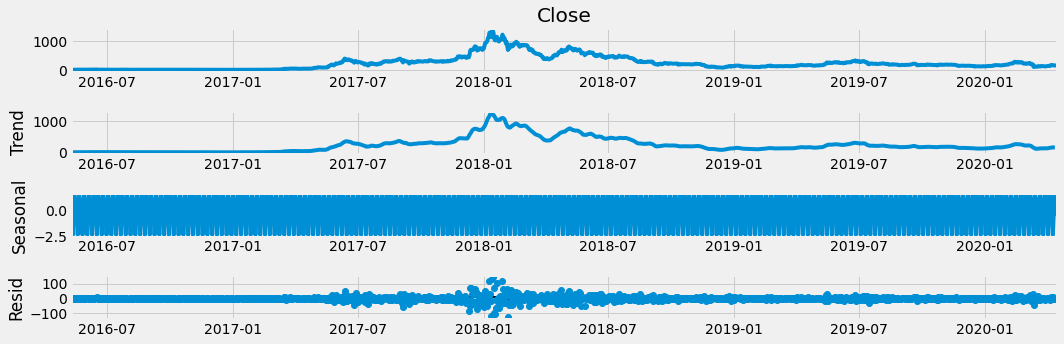

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive')
decomposition.plot()                               
plt.show()

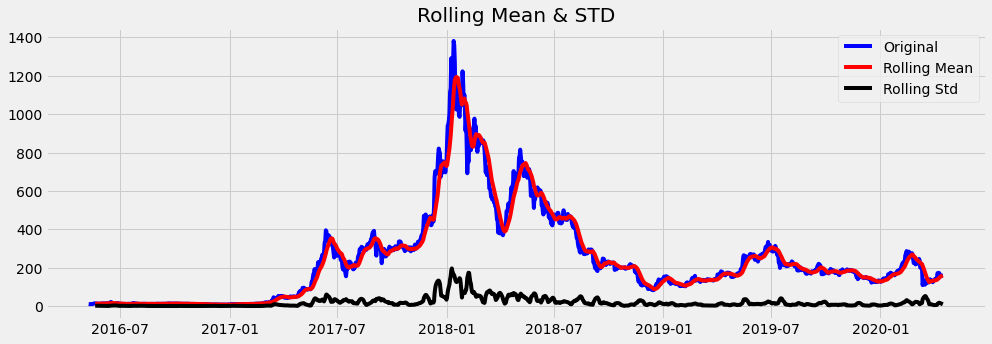

In [ ]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()
original = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.show()

In [ ]:
ADF(df['Close'])

ADF Statistic: -2.1424854426189097
n_lags: 24
p-value: 0.22777753891098423411
Critial Values:
   1%, -3.4349863902854607
Critial Values:
   5%, -2.863587640846308
Critial Values:
   10%, -2.567860154259632


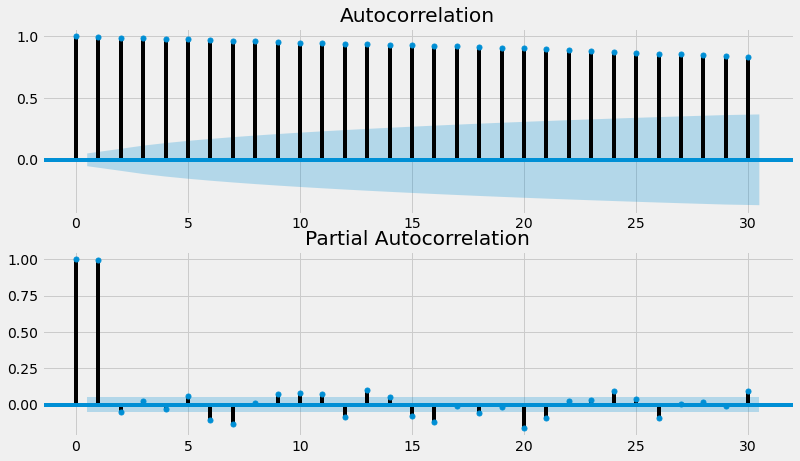

In [ ]:
ACF_and_PACF(df['Close'])

# Modelling

In [ ]:
data = df['Close'].values
data = data.astype('float32')
data = np.expand_dims(data, axis=-1)
print(data.shape)

(1438, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

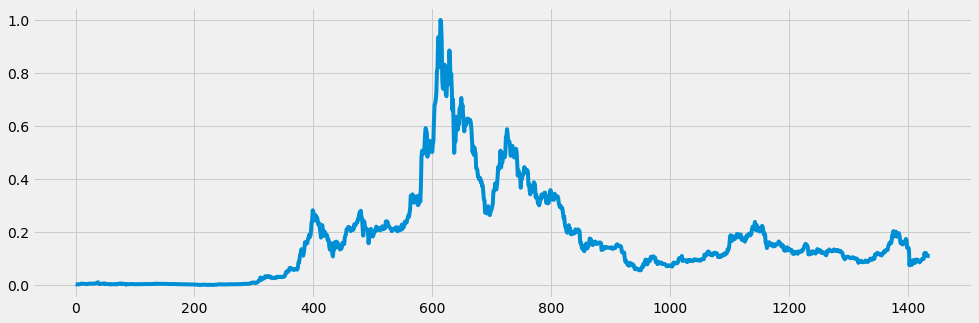

In [ ]:
plt.plot(data)

In [ ]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]
print(train_size, test_size)

1150 288


In [ ]:
threshold_mae = (train.max() - train.min()) * 10/100
threshold_mae

0.1

In [ ]:
def to_sequences(dataset, seq_size):
    x = []
    y = []

    for i in range(len(dataset) - seq_size - 1):
        window = dataset[i:(i + seq_size), 0]
        x.append(window)
        y.append(dataset[i + seq_size, 0])
        
    return np.array(x),np.array(y)

In [ ]:
seq_size = 60
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [ ]:
print("Shape of training set:", trainX.shape, trainY.shape)
print("Shape of test set: ", testX.shape, testY.shape)

Shape of training set: (1089, 60) (1089,)
Shape of test set:  (227, 60) (227,)


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(1089, 1, 60) (227, 1, 60)


In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, input_shape=(None, seq_size), return_sequences=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 dropout (Dropout)           (None, None, 60)          0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                3

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(trainX, trainY, 
                    validation_data=(testX, testY), 
                    verbose=2, epochs=100)

Epoch 1/100
35/35 - 6s - loss: 0.0304 - mae: 0.1704 - val_loss: 0.0044 - val_mae: 0.0895 - 6s/epoch - 183ms/step
Epoch 2/100
35/35 - 0s - loss: 0.0222 - mae: 0.1423 - val_loss: 0.0013 - val_mae: 0.0442 - 224ms/epoch - 6ms/step
Epoch 3/100
35/35 - 0s - loss: 0.0125 - mae: 0.1028 - val_loss: 3.9138e-04 - val_mae: 0.0217 - 231ms/epoch - 7ms/step
Epoch 4/100
35/35 - 0s - loss: 0.0069 - mae: 0.0813 - val_loss: 0.0011 - val_mae: 0.0431 - 229ms/epoch - 7ms/step
Epoch 5/100
35/35 - 0s - loss: 0.0056 - mae: 0.0765 - val_loss: 0.0010 - val_mae: 0.0405 - 246ms/epoch - 7ms/step
Epoch 6/100
35/35 - 0s - loss: 0.0052 - mae: 0.0730 - val_loss: 7.8749e-04 - val_mae: 0.0349 - 239ms/epoch - 7ms/step
Epoch 7/100
35/35 - 0s - loss: 0.0053 - mae: 0.0707 - val_loss: 6.3199e-04 - val_mae: 0.0304 - 240ms/epoch - 7ms/step
Epoch 8/100
35/35 - 0s - loss: 0.0046 - mae: 0.0654 - val_loss: 5.2383e-04 - val_mae: 0.0269 - 236ms/epoch - 7ms/step
Epoch 9/100
35/35 - 0s - loss: 0.0045 - mae: 0.0637 - val_loss: 3.6517e-0

8/8 [==============================] - 0s 3ms/step
Train Score: 5.12 MAE
Test Score: 3.55 MAE


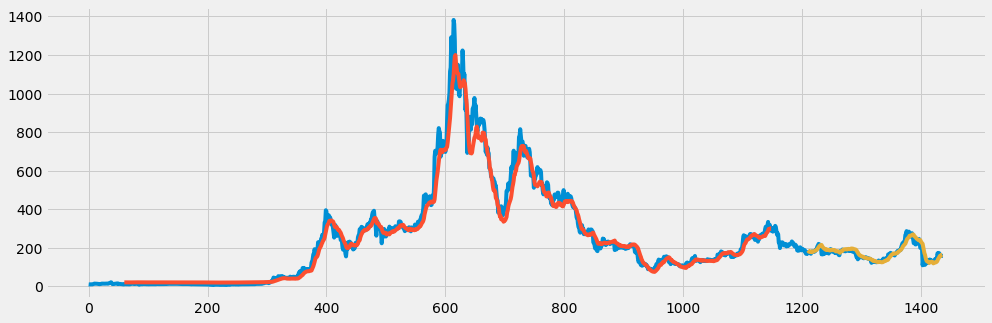

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainScore))

testScore = math.sqrt(mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f MAE' % (testScore))

trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict) + seq_size, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (seq_size * 2) + 1:len(data) - 1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()